In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.
//anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
//anaconda3/envs/myenv/lib/python3.6/site-packages/tenso

In [5]:
stock_name = '^GSPC'
seq_len = 22
d = 0.2
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 300

In [6]:
def get_stock_data(stock_name, normalize=True):
    start = datetime.datetime(1971, 1, 1)
    end = datetime.date.today()
    df = web.DataReader(stock_name, "yahoo", start, end)
    df.drop(['Volume', 'Close'], 1, inplace=True)
    
    if normalize:        
        min_max_scaler = preprocessing.MinMaxScaler()
        df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
        df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
        df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
        df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
    return df
 
df = get_stock_data(stock_name, normalize=True)

                High       Low      Open  Adj Close
Date                                               
1970-12-31  0.009970  0.010293  0.010124   0.010079
1971-01-04  0.009768  0.010050  0.010084   0.009742
1971-01-05  0.009798  0.010067  0.009746   0.009961
1971-01-06  0.010041  0.010341  0.009966   0.010147
1971-01-07  0.010129  0.010425  0.010151   0.010157


//anaconda3/envs/myenv/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


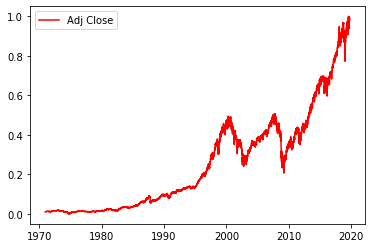

In [7]:
def plot_stock(stock_name):
    df = get_stock_data(stock_name, normalize=True)
    print(df.head())
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.show()
plot_stock(stock_name)

In [8]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    
    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price
    
    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1] 
 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  
 
    return [X_train, y_train, X_test, y_test]
X_train, y_train, X_test, y_test = load_data(df, seq_len)

//anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
def build_model2(layers, neurons, d):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[2]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    adam = keras.optimizers.Adam(decay=0.2)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model
 
model = build_model2(shape, neurons, d)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 128)           68096     
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
________________________________________________

In [10]:
history=model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.1,
    verbose=1)


Train on 9937 samples, validate on 1105 samples
Epoch 1/300
9937/9937 [==============================] - 5s 471us/step - loss: 0.0234 - accuracy: 1.0063e-04 - val_loss: 0.0308 - val_accuracy: 0.0000e+00
Epoch 2/300
9937/9937 [==============================] - 4s 407us/step - loss: 0.0014 - accuracy: 1.0063e-04 - val_loss: 0.0046 - val_accuracy: 0.0000e+00
Epoch 3/300
9937/9937 [==============================] - 4s 408us/step - loss: 4.9355e-04 - accuracy: 1.0063e-04 - val_loss: 0.0065 - val_accuracy: 0.0000e+00
Epoch 4/300
9937/9937 [==============================] - 4s 404us/step - loss: 3.0783e-04 - accuracy: 1.0063e-04 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 5/300
9937/9937 [==============================] - 4s 409us/step - loss: 2.4960e-04 - accuracy: 1.0063e-04 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 6/300
9937/9937 [==============================] - 4s 402us/step - loss: 2.1731e-04 - accuracy: 1.0063e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch

Epoch 50/300
9937/9937 [==============================] - 4s 398us/step - loss: 1.3286e-04 - accuracy: 1.0063e-04 - val_loss: 2.7334e-04 - val_accuracy: 0.0000e+00
Epoch 51/300
9937/9937 [==============================] - 4s 416us/step - loss: 1.2735e-04 - accuracy: 1.0063e-04 - val_loss: 2.4275e-04 - val_accuracy: 0.0000e+00
Epoch 52/300
9937/9937 [==============================] - 4s 415us/step - loss: 1.3013e-04 - accuracy: 1.0063e-04 - val_loss: 1.9186e-04 - val_accuracy: 0.0000e+00
Epoch 53/300
9937/9937 [==============================] - 4s 406us/step - loss: 1.2737e-04 - accuracy: 1.0063e-04 - val_loss: 3.1477e-04 - val_accuracy: 0.0000e+00
Epoch 54/300
9937/9937 [==============================] - 4s 434us/step - loss: 1.1858e-04 - accuracy: 1.0063e-04 - val_loss: 1.8190e-04 - val_accuracy: 0.0000e+00
Epoch 55/300
9937/9937 [==============================] - 4s 419us/step - loss: 1.1637e-04 - accuracy: 1.0063e-04 - val_loss: 3.4653e-04 - val_accuracy: 0.0000e+00
Epoch 56/300
993

Epoch 100/300
9937/9937 [==============================] - 4s 411us/step - loss: 9.6096e-05 - accuracy: 1.0063e-04 - val_loss: 7.2515e-05 - val_accuracy: 0.0000e+00
Epoch 101/300
9937/9937 [==============================] - 4s 424us/step - loss: 9.0205e-05 - accuracy: 1.0063e-04 - val_loss: 7.4738e-05 - val_accuracy: 0.0000e+00
Epoch 102/300
9937/9937 [==============================] - 4s 400us/step - loss: 9.7083e-05 - accuracy: 1.0063e-04 - val_loss: 5.0749e-04 - val_accuracy: 0.0000e+00
Epoch 103/300
9937/9937 [==============================] - 4s 415us/step - loss: 9.6545e-05 - accuracy: 1.0063e-04 - val_loss: 2.3759e-04 - val_accuracy: 0.0000e+00
Epoch 104/300
9937/9937 [==============================] - 4s 401us/step - loss: 9.0384e-05 - accuracy: 1.0063e-04 - val_loss: 1.8131e-04 - val_accuracy: 0.0000e+00
Epoch 105/300
9937/9937 [==============================] - 4s 409us/step - loss: 9.3062e-05 - accuracy: 1.0063e-04 - val_loss: 8.4232e-05 - val_accuracy: 0.0000e+00
Epoch 106/

Epoch 199/300
9937/9937 [==============================] - 4s 412us/step - loss: 5.0961e-05 - accuracy: 1.0063e-04 - val_loss: 6.7997e-05 - val_accuracy: 0.0000e+00
Epoch 200/300
9937/9937 [==============================] - 4s 443us/step - loss: 5.2403e-05 - accuracy: 1.0063e-04 - val_loss: 8.1713e-05 - val_accuracy: 0.0000e+00
Epoch 201/300
9937/9937 [==============================] - 4s 423us/step - loss: 5.0636e-05 - accuracy: 1.0063e-04 - val_loss: 3.0164e-04 - val_accuracy: 0.0000e+00
Epoch 202/300
9937/9937 [==============================] - 4s 411us/step - loss: 5.6751e-05 - accuracy: 1.0063e-04 - val_loss: 9.3459e-05 - val_accuracy: 0.0000e+00
Epoch 203/300
9937/9937 [==============================] - 4s 432us/step - loss: 5.9089e-05 - accuracy: 1.0063e-04 - val_loss: 7.2004e-05 - val_accuracy: 0.0000e+00
Epoch 204/300
9937/9937 [==============================] - 4s 432us/step - loss: 5.2167e-05 - accuracy: 1.0063e-04 - val_loss: 6.4373e-05 - val_accuracy: 0.0000e+00
Epoch 205/

Epoch 298/300
9937/9937 [==============================] - 4s 404us/step - loss: 3.5936e-05 - accuracy: 1.0063e-04 - val_loss: 5.0782e-05 - val_accuracy: 0.0000e+00
Epoch 299/300
9937/9937 [==============================] - 4s 404us/step - loss: 3.5274e-05 - accuracy: 1.0063e-04 - val_loss: 4.6413e-05 - val_accuracy: 0.0000e+00
Epoch 300/300
9937/9937 [==============================] - 4s 408us/step - loss: 4.0869e-05 - accuracy: 1.0063e-04 - val_loss: 6.1479e-05 - val_accuracy: 0.0000e+00


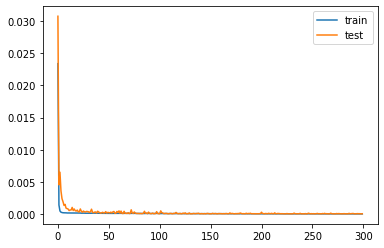

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [12]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
 
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]
 
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00002 MSE (0.00 RMSE)
Test Score: 0.00508 MSE (0.07 RMSE)


(2.2864146579568673e-05, 0.005082234837412348)

In [13]:
def model_score(model, X_train, y_train, X_test, y_test):
#其实这里只需要传入X_test和y_test即可，只是为了和上面格式保持一致因而也将X_train和y_train传入了    
    y_hat = model.predict(X_test)
    y_t=y_test.reshape(-1,1)
    
    temp = pd.DataFrame(y_hat)  
    temp['yhat']=y_hat
    temp['y']=y_t
    temp_rmse = sqrt(mean_squared_error(temp.y,temp.yhat))
    temp_mse=mean_squared_error(temp.y,temp.yhat)
    print('TEMP RMSE: %.3f' % temp_rmse)
    print('TEMP MSE: %.3f' % temp_mse)
    return temp_rmse,temp_mse
 
model_score(model, X_train, y_train, X_test, y_test)

TEMP RMSE: 0.071
TEMP MSE: 0.005


(0.07128979081059487, 0.0050822342738183765)

In [14]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]
 
    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u
 
        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p
p = percentage_difference(model, X_test, y_test)

In [15]:
def denormalize(stock_name, normalized_value):
    start = datetime.datetime(2000, 1, 1)
    end = datetime.date.today()
    df = web.DataReader(stock_name, "yahoo", start, end)
    
    df = df['Adj Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

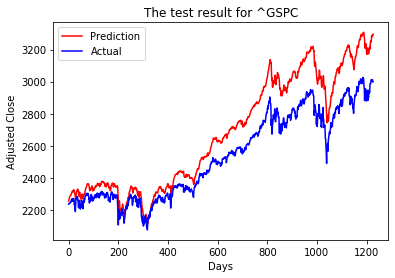

In [17]:
def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(stock_name, normalized_value_p)
    newy_test = denormalize(stock_name, normalized_value_y_test)
    plt.plot(newp, color='red', label='Prediction')
    plt.plot(newy_test,color='blue', label='Actual')
    plt.legend(loc='best')
    plt.title('The test result for {}'.format(stock_name))
    plt.xlabel('Days')
    plt.ylabel('Adjusted Close')
    plt.show()
 
plot_result(stock_name, p, y_test)

In [18]:
model.save('LSTM_Stock_prediction-20170429.h5')